# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, BitsAndBytesConfig
from transformers import BertTokenizer, RobertaTokenizer, DistilBertTokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, DistilBertForSequenceClassification

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import matplotlib.pyplot as plt


c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset and remove duplicate

In [2]:
data = pd.read_csv('ScamDataset.csv', delimiter=',', names=['message', 'label'])

original_shape = data.shape

# Removing duplicate rows
data = data.drop_duplicates()

# Shape after removing duplicates
new_shape = data.shape

original_shape, new_shape

((20670, 2), (15241, 2))

In [3]:
# Shuffle data to avoid any bias
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
data['label'] = data['label'].astype('category')
data['target'] = data['label'].cat.codes
data


,message,label,target
0,Important notice: Your tax refund requires urg...,fraud,0
1,Huh so early.. Then you having dinner outside ...,normal,1
2,Important notice: Your account verification re...,fraud,0
3,Important notice: Your account verification re...,fraud,0
4,Omg it could snow here tonite!,normal,1
...,...,...,...
15236,"Good afternoon, this is the front desk at The ...",normal,1
15237,Yar lor... How u noe? U used dat route too?,normal,1
15238,received this phone call from our department i...,fraud,0
15239,I am in bus on the way to calicut,normal,1


In [5]:
# Decode
data['label'].cat.categories
category_map = {code: category for code, category in enumerate(data['label'].cat.categories)}
category_map

{0: 'fraud', 1: 'normal'}

In [6]:
train_end_point = int(data.shape[0]*0.6)
val_end_point = int(data.shape[0]*0.8)
df_train = data.iloc[:train_end_point,:]
df_val = data.iloc[train_end_point:val_end_point,:]
df_test = data.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(9144, 3) (3049, 3) (3048, 3)


In [7]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))

In [8]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [9]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'target'],
        num_rows: 9144
    })
    val: Dataset({
        features: ['message', 'target'],
        num_rows: 3048
    })
    test: Dataset({
        features: ['message', 'target'],
        num_rows: 3049
    })
})

In [10]:
dataset['train']

Dataset({
    features: ['message', 'target'],
    num_rows: 9144
})

In [11]:
df_train.target.value_counts(normalize=True)

target
0    0.550087
1    0.449913
Name: proportion, dtype: float64

In [12]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.4499, 0.5501])

In [13]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

In [14]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [15]:
# Define function for training and evaluation
def tokenizer_model(model_name):
    print(f"Training and evaluating {model_name}...")
    if model_name == 'bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', add_prefix_space=True)
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    elif model_name == 'roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base', add_prefix_space=True)
        model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    elif model_name == 'distilbert':
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', add_prefix_space=True)
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
   

    else:
        raise Exception("Model not supported")
    
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    model.to(torch.device("cuda"))
    
    return tokenizer, model





In [16]:
messages = df_test.message.tolist()
messages

['Important notice: Your prize claim requires urgent attention. Act as soon as possible to avoid issues. Ref: 1566',
 'U definitely need a module from e humanities dis sem izzit? U wan 2 take other modules 1st?',
 "Hi this is Officer Sarah Jones calling you from the legal department. The very second you read this message you need to leave your work aside so that we can discuss about your case and take necessary action. On this matter in order to connect press one and you will be connected to the concerned department. If we don't hear from you IT will be forced to take legal action against you. ",
 'Important notice: Your account verification requires urgent attention. Act immediately to avoid issues. Ref: 9796',
 "This is your reminder from KKH Women's and Children's Hospital about your appointment with Dr. Susan Lee on Monday at 10 AM in the maternity wing. Please bring your referral letter and any recent test results.",
 'Important notice: Your tax refund requires urgent attention. A

In [17]:
# Convert summaries to a list
messages = df_test.message.tolist()

In [18]:
evaluation_results = {}

In [19]:
def get_performance_metrics(model_name,df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  y_test = y_test.astype('category')
  y_pred = y_pred.astype('category')

  y_test = y_test.cat.codes
  y_pred = y_pred.cat.codes

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)


  evaluation_results[model_name] = {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  }

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

  # Plot confusion matrix
  labels = ['fraud', 'normal']
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix: {model_name}')
  plt.show()
  

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [21]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [22]:
def train_model(tokenizer, model, model_name):
    MAX_LEN = 512
    col_to_delete = ['message']

    def preprocessing_function(examples):
        return tokenizer(examples['message'], truncation=True, max_length=MAX_LEN)

    tokenized_datasets = dataset.map(preprocessing_function, batched=True, remove_columns=col_to_delete)
    tokenized_datasets = tokenized_datasets.rename_column("target", "label")
    tokenized_datasets.set_format("torch")

    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir = 'sentiment_classification',
        learning_rate = 1e-4,
        per_device_train_batch_size = 8,
        per_device_eval_batch_size = 8,
        num_train_epochs = 3,
        weight_decay = 0.01,
        eval_strategy = 'epoch',
        save_strategy = 'epoch',
        load_best_model_at_end = True
    )

    trainer = CustomTrainer(
        model = model,
        args = training_args,
        train_dataset = tokenized_datasets['train'],
        eval_dataset = tokenized_datasets['val'],
        tokenizer = tokenizer,
        data_collator = collate_fn,
        compute_metrics = compute_metrics,
        class_weights=class_weights,
    )

    train_result = trainer.train()

    metrics = train_result.metrics
    max_train_samples = len(dataset_train)
    metrics["train_samples"] = min(max_train_samples, len(dataset_train))
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()
    trainer.save_model("./models/tuned_"+model_name+"_model")


In [23]:
def make_predictions(tokenizer,model,df_test):
  # Convert summaries to a list
  messages = df_test.message.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(messages), batch_size):
      # Get the batch of sentences
      batch_messages = messages[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
      
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


# Bert

In [24]:
tokenizer, model = tokenizer_model('bert')
train_model(tokenizer, model, 'bert')


Training and evaluating bert...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3049/3049 [00:00<00:00, 4412.88 examples/s]
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
  0%|          | 0/3429 [00:00<?, ?it/s]c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transform

{'loss': 0.1005, 'grad_norm': 0.025056637823581696, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1003/3429 [01:03<02:33, 15.86it/s]

{'loss': 0.0924, 'grad_norm': 0.05532846972346306, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


                                                   
 33%|███▎      | 1143/3429 [01:16<02:21, 16.17it/s]

{'eval_loss': 0.09549811482429504, 'eval_balanced_accuracy': 0.9837430966912502, 'eval_accuracy': 0.984251968503937, 'eval_runtime': 4.3999, 'eval_samples_per_second': 692.749, 'eval_steps_per_second': 86.594, 'epoch': 1.0}


 44%|████▍     | 1503/3429 [01:40<01:59, 16.18it/s]

{'loss': 0.1095, 'grad_norm': 0.058605704456567764, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2003/3429 [02:11<01:29, 15.99it/s]

{'loss': 0.0617, 'grad_norm': 0.3033199906349182, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


                                                   
 67%|██████▋   | 2286/3429 [02:34<01:12, 15.68it/s]

{'eval_loss': 0.1374930590391159, 'eval_balanced_accuracy': 0.9774626522958314, 'eval_accuracy': 0.9763779527559056, 'eval_runtime': 4.4543, 'eval_samples_per_second': 684.277, 'eval_steps_per_second': 85.535, 'epoch': 2.0}


 73%|███████▎  | 2503/3429 [02:48<01:00, 15.30it/s]

{'loss': 0.0984, 'grad_norm': 0.04770529642701149, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3003/3429 [03:20<00:25, 16.56it/s]

{'loss': 0.0455, 'grad_norm': 0.03833915665745735, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


                                                   
100%|██████████| 3429/3429 [03:51<00:00, 16.53it/s]

{'eval_loss': 0.0800432339310646, 'eval_balanced_accuracy': 0.985718186028187, 'eval_accuracy': 0.9862204724409449, 'eval_runtime': 4.2951, 'eval_samples_per_second': 709.64, 'eval_steps_per_second': 88.705, 'epoch': 3.0}


100%|██████████| 3429/3429 [03:52<00:00, 14.76it/s]


{'train_runtime': 232.303, 'train_samples_per_second': 118.087, 'train_steps_per_second': 14.761, 'train_loss': 0.08170779504383852, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   773610GF
  train_loss               =     0.0817
  train_runtime            = 0:03:52.30
  train_samples            =       9144
  train_samples_per_second =    118.087
  train_steps_per_second   =     14.761


Accuracy: 0.9938
Precision: 0.9900
Recall: 0.9964
F1-Score: 0.9932
Confusion Matrix:
[[1645   14]
 [   5 1385]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1659
           1       0.99      1.00      0.99      1390

    accuracy                           0.99      3049
   macro avg       0.99      0.99      0.99      3049
weighted avg       0.99      0.99      0.99      3049

Balanced Accuracy Score: 0.9939820295662205
Accuracy Score: 0.9937684486716957


C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\2986263682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\2986263682.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


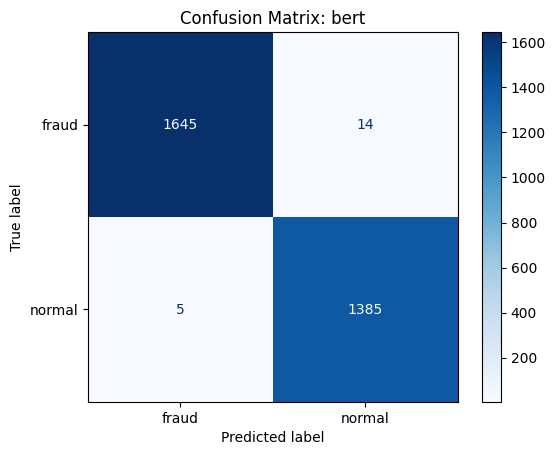

In [25]:
make_predictions(tokenizer,model,df_test)
get_performance_metrics('bert',df_test)

# Roberta

In [26]:
tokenizer, model = tokenizer_model('roberta')
train_model(tokenizer, model, 'roberta')


Training and evaluating roberta...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3049/3049 [00:00<00:00, 7741.78 examples/s]
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
 15%|█▍        | 502/3429 [00:36<03:36, 13.50it/s]

{'loss': 0.6386, 'grad_norm': 1.3183048963546753, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1002/3429 [01:13<03:01, 13.40it/s]

{'loss': 0.7037, 'grad_norm': 3.7141973972320557, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


 33%|███▎      | 1142/3429 [01:23<02:56, 12.95it/s]c:\Users\Potbottom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2466: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")

 33%|███▎      | 1143/3429 [01:29<02:56, 12.95it/s]

{'eval_loss': 0.7053651213645935, 'eval_balanced_accuracy': 0.463254593175853, 'eval_accuracy': 0.463254593175853, 'eval_runtime': 5.1947, 'eval_samples_per_second': 586.757, 'eval_steps_per_second': 73.345, 'epoch': 1.0}


 44%|████▍     | 1502/3429 [01:57<02:26, 13.13it/s]

{'loss': 0.7, 'grad_norm': 1.1027722358703613, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2002/3429 [02:33<01:42, 13.88it/s]

{'loss': 0.6523, 'grad_norm': 0.43915224075317383, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


 67%|██████▋   | 2286/3429 [02:59<01:20, 14.13it/s]

{'eval_loss': 0.21930059790611267, 'eval_balanced_accuracy': 0.953652559489383, 'eval_accuracy': 0.9543963254593176, 'eval_runtime': 4.8604, 'eval_samples_per_second': 627.105, 'eval_steps_per_second': 78.388, 'epoch': 2.0}


 73%|███████▎  | 2502/3429 [03:16<01:06, 13.93it/s]

{'loss': 0.1815, 'grad_norm': 0.2962058484554291, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3002/3429 [03:53<00:31, 13.65it/s]

{'loss': 0.1823, 'grad_norm': 0.7499057650566101, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


100%|██████████| 3429/3429 [04:30<00:00, 13.85it/s]

{'eval_loss': 0.3406619131565094, 'eval_balanced_accuracy': 0.8860418216145088, 'eval_accuracy': 0.8648293963254593, 'eval_runtime': 4.7645, 'eval_samples_per_second': 639.731, 'eval_steps_per_second': 79.966, 'epoch': 3.0}


100%|██████████| 3429/3429 [04:31<00:00, 12.61it/s]


{'train_runtime': 271.8749, 'train_samples_per_second': 100.899, 'train_steps_per_second': 12.612, 'train_loss': 0.4816297796454642, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   776769GF
  train_loss               =     0.4816
  train_runtime            = 0:04:31.87
  train_samples            =       9144
  train_samples_per_second =    100.899
  train_steps_per_second   =     12.612


Accuracy: 0.9649
Precision: 0.9579
Recall: 0.9655
F1-Score: 0.9617
Confusion Matrix:
[[1600   59]
 [  48 1342]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1659
           1       0.96      0.97      0.96      1390

    accuracy                           0.96      3049
   macro avg       0.96      0.96      0.96      3049
weighted avg       0.96      0.96      0.96      3049

Balanced Accuracy Score: 0.9649520166868314
Accuracy Score: 0.9649065267300755


C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\2986263682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\2986263682.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


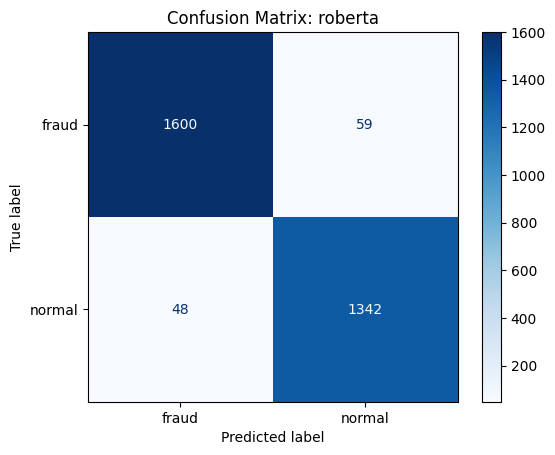

In [27]:
make_predictions(tokenizer,model,df_test)
get_performance_metrics('roberta', df_test)

# Distilbert

In [28]:
tokenizer, model = tokenizer_model('distilbert')
train_model(tokenizer, model, 'distilbert')


Training and evaluating distilbert...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3049/3049 [00:00<00:00, 4337.02 examples/s]
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\4162890314.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
 15%|█▍        | 503/3429 [00:20<02:03, 23.72it/s]

{'loss': 0.0891, 'grad_norm': 0.00795496441423893, 'learning_rate': 8.541848935549723e-05, 'epoch': 0.44}


 29%|██▉       | 1005/3429 [00:40<01:34, 25.78it/s]

{'loss': 0.05, 'grad_norm': 0.009871934540569782, 'learning_rate': 7.083697871099446e-05, 'epoch': 0.87}


 33%|███▎      | 1143/3429 [00:48<01:30, 25.38it/s]

{'eval_loss': 0.07471075654029846, 'eval_balanced_accuracy': 0.9863074151543363, 'eval_accuracy': 0.9868766404199475, 'eval_runtime': 2.8443, 'eval_samples_per_second': 1071.621, 'eval_steps_per_second': 133.953, 'epoch': 1.0}


 44%|████▍     | 1504/3429 [01:03<01:16, 25.27it/s]

{'loss': 0.0424, 'grad_norm': 0.01170080155134201, 'learning_rate': 5.625546806649169e-05, 'epoch': 1.31}


 58%|█████▊    | 2005/3429 [01:23<00:54, 26.02it/s]

{'loss': 0.0163, 'grad_norm': 0.0162111297249794, 'learning_rate': 4.167395742198892e-05, 'epoch': 1.75}


 67%|██████▋   | 2286/3429 [01:37<00:44, 25.85it/s]

{'eval_loss': 0.052080124616622925, 'eval_balanced_accuracy': 0.9897542506936821, 'eval_accuracy': 0.9901574803149606, 'eval_runtime': 2.8968, 'eval_samples_per_second': 1052.2, 'eval_steps_per_second': 131.525, 'epoch': 2.0}


 73%|███████▎  | 2503/3429 [01:46<00:36, 25.72it/s]

{'loss': 0.0195, 'grad_norm': 0.017257127910852432, 'learning_rate': 2.7092446777486146e-05, 'epoch': 2.19}


 88%|████████▊ | 3005/3429 [02:05<00:15, 26.77it/s]

{'loss': 0.0099, 'grad_norm': 0.004308411385864019, 'learning_rate': 1.2510936132983377e-05, 'epoch': 2.62}


100%|██████████| 3429/3429 [02:25<00:00, 25.91it/s]

{'eval_loss': 0.06303606182336807, 'eval_balanced_accuracy': 0.9902414264563465, 'eval_accuracy': 0.990485564304462, 'eval_runtime': 2.7858, 'eval_samples_per_second': 1094.132, 'eval_steps_per_second': 136.767, 'epoch': 3.0}


100%|██████████| 3429/3429 [02:25<00:00, 23.50it/s]

{'train_runtime': 145.9374, 'train_samples_per_second': 187.971, 'train_steps_per_second': 23.496, 'train_loss': 0.03483114954541535, 'epoch': 3.0}
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   389486GF
  train_loss               =     0.0348
  train_runtime            = 0:02:25.93
  train_samples            =       9144
  train_samples_per_second =    187.971
  train_steps_per_second   =     23.496


Accuracy: 0.9934
Precision: 0.9893
Recall: 0.9964
F1-Score: 0.9928
Confusion Matrix:
[[1644   15]
 [   5 1385]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1659
           1       0.99      1.00      0.99      1390

    accuracy                           0.99      3049
   macro avg       0.99      0.99      0.99      3049
weighted avg       0.99      0.99      0.99      3049

Balanced Accuracy Score: 0.9936806431888847
Accuracy Score: 0.9934404722859954


C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\2986263682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
C:\Users\Potbottom\AppData\Local\Temp\ipykernel_21064\2986263682.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


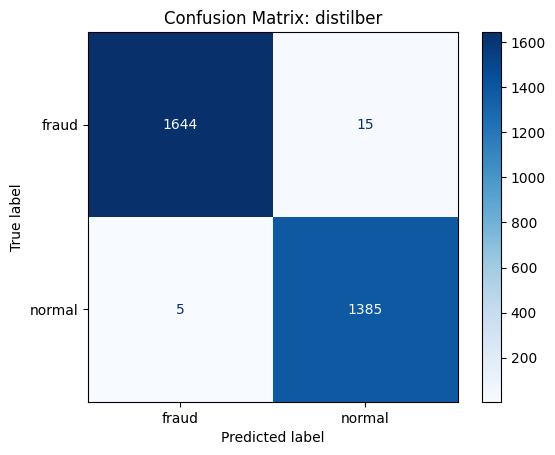

In [29]:
make_predictions(tokenizer,model,df_test)
get_performance_metrics('distilber', df_test)

# Plot evaluation comparison

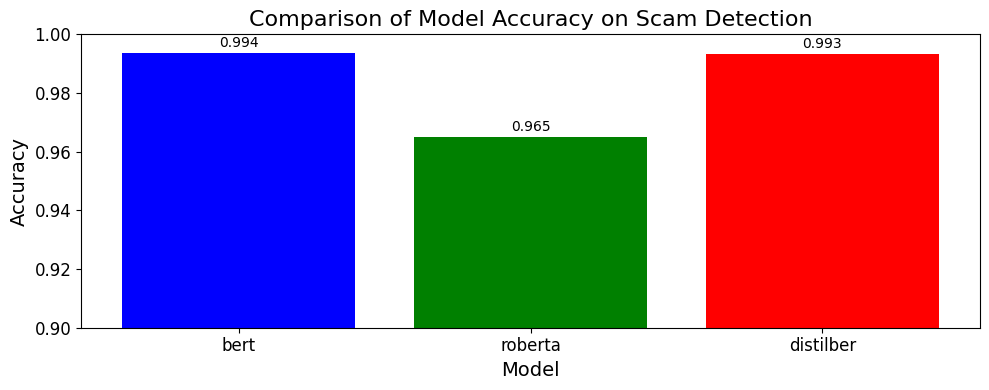

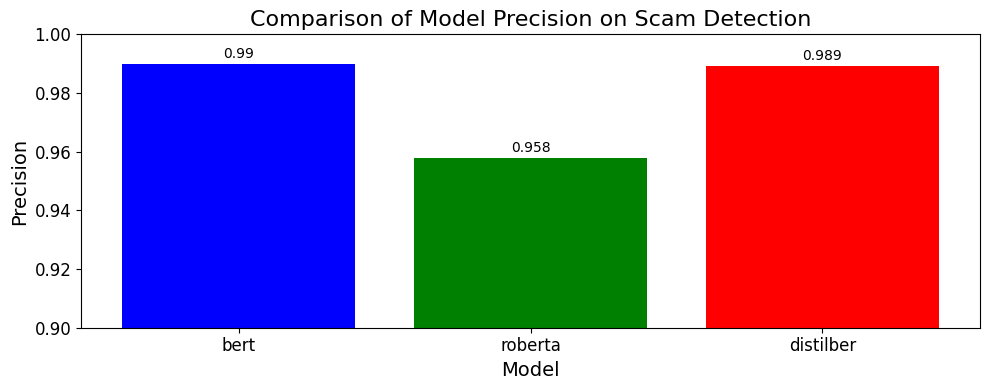

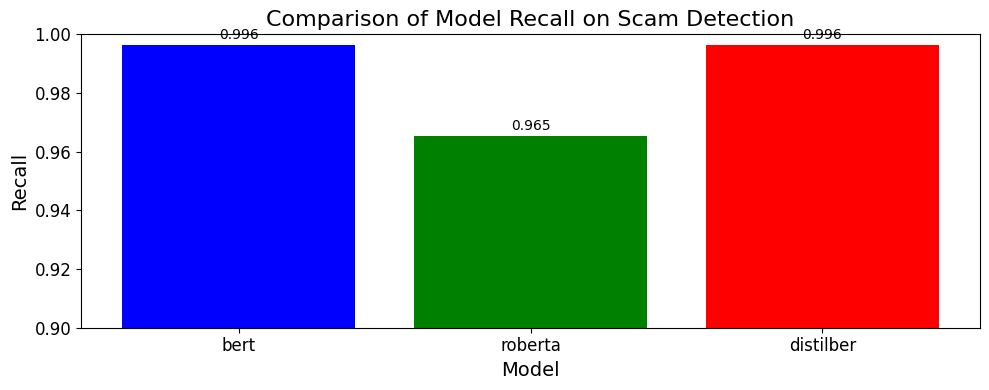

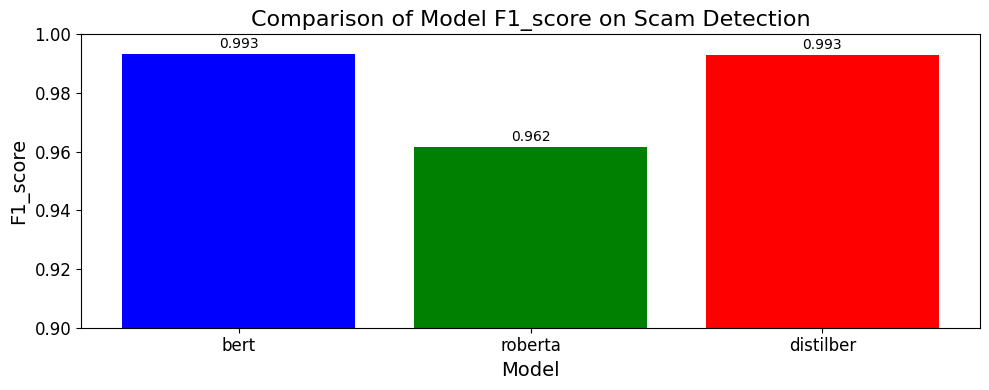

In [30]:
# Plot the evaluation metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plt.figure(figsize=(10, 4))
    bars = plt.bar(evaluation_results.keys(), [evaluation_results[model][metric] for model in evaluation_results], color=['blue', 'green', 'red', 'purple', 'yellow'])
    
  # Add data labels above each bar for clarity
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 3), ha='center', va='bottom')

    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.title(f'Comparison of Model {metric.capitalize()} on Scam Detection', fontsize=16)
    plt.ylim(0.9, 1)  # Set y-axis limit to make differences more distinct
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()